In [5]:
# Core scverse libraries
from __future__ import annotations

import anndata as ad

# Data retrieval
import pooch
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import scrublet as scr
%matplotlib inline

In [2]:
#sc.settings.set_figure_params(dpi=50, facecolor="white")

## Read data
The dataset used:
https://www.10xgenomics.com/datasets/pbm-cs-of-a-healthy-donor-v-1-1-1-standard-3-1-0

The data is an mtx directory with an mtx file (i.e. count matrix), two tsv files with barcodes (i.e. cell indices) and features (i.e. gene symbols). Scanpy unpacks the files (if the files are in gz archive format) and creates an anndata object with the read_10x_mtx function.

In [6]:
!/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/bin/wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz
!/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/bin/tar -xvf vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz
print("Data downloaded")

--2026-01-07 10:11:47--  https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40522127 (39M) [application/x-tar]
Saving to: ‘vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz’

vdj_v1_hs_pbmc3_fil 100%[===================>]  38.64M   109MB/s    in 0.4s    

2026-01-07 10:11:48 (109 MB/s) - ‘vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz’ saved [40522127/40522127]

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/barcodes.tsv.gz
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz
Data downloaded


In [7]:
file_path_raw = './filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(path=file_path_raw)

Check the size of the data

In [8]:
adata.shape

(7231, 33538)

In [9]:
print('Total number of observations: {:d}'.format(adata.n_obs))

Total number of observations: 7231


## Quality control
Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

We start with calculating the QC covariates:
* total number of counts per cell
* number of expressed genes per cell
* fraction of mitochondrial reads per cell

In [10]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

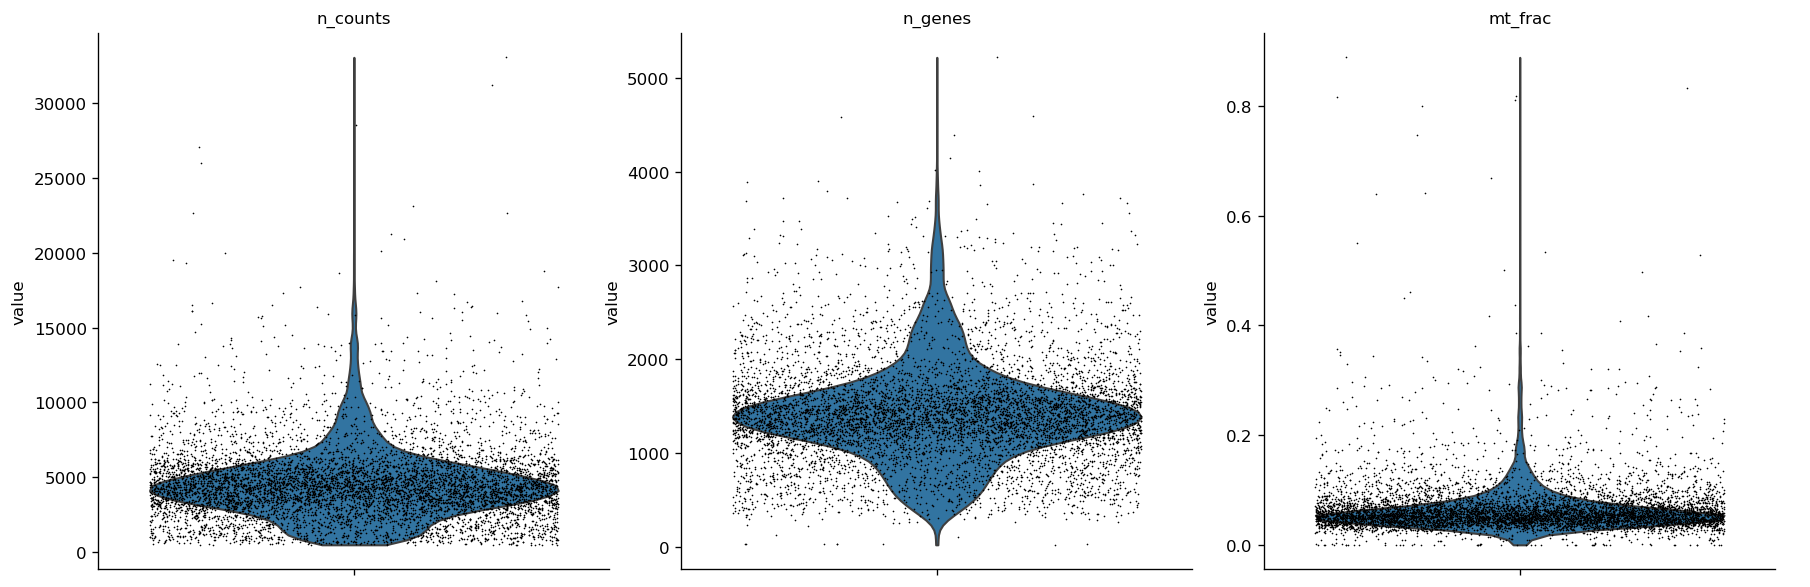

In [11]:
plt.rcParams["figure.figsize"] = (12, 4)   # width, height in inches
plt.rcParams["figure.dpi"] = 120
sc.pl.violin(
    adata,
    ["n_counts", "n_genes", "mt_frac"],
    jitter=0.4,
    multi_panel=True,
)

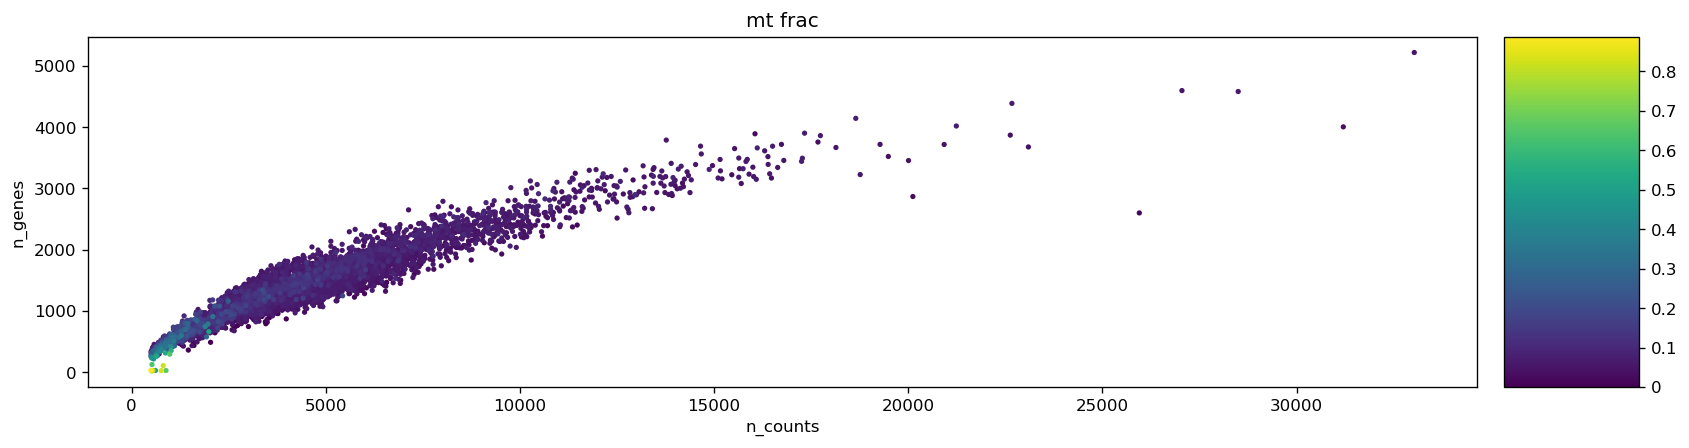

In [12]:
sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=40)

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [13]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 7231
Number of cells after min count filter: 6980
Number of cells after max count filter: 6968
Number of cells after MT filter: 6910
Number of cells after gene filter: 6618


/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/lib/python3.14/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [14]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33538
Number of genes after cell filter: 13290


# Doublet score
Let us estimate the amount of doublets in the dataset.

In [15]:
adata.obs['doublet_score']= np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [16]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.04
Detected doublet rate = 17.4%
Estimated detectable doublet fraction = 83.3%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 20.9%
Elapsed time: 5.4 seconds


## filtering doublets
Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

In [17]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 5774


## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. 

Several methods for normalization for scRNA-seq data have been proposed. Here, we normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.

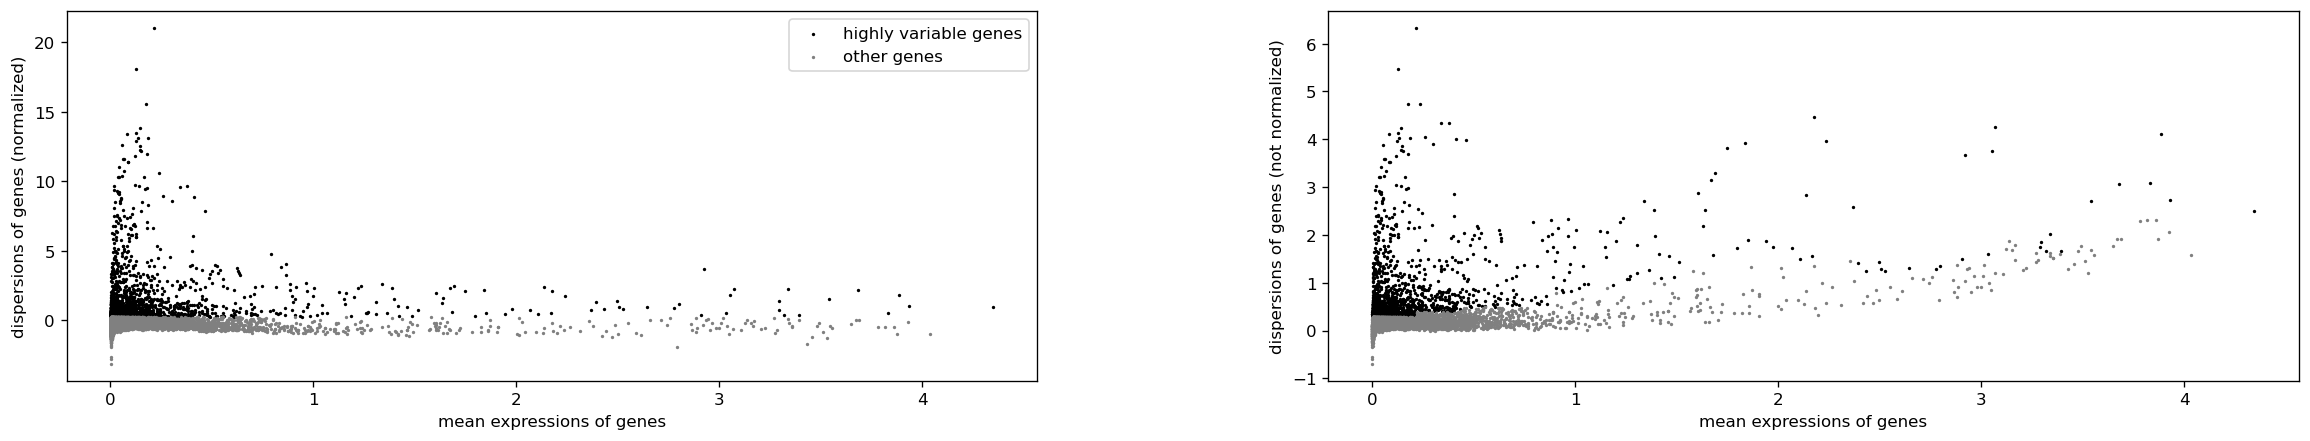

In [24]:
adata.layers["counts"] = adata.X.copy()

adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
adata_pp.layers["norm"] = adata_pp.X.copy()
sc.pp.log1p(adata_pp)
sc.pp.highly_variable_genes(adata_pp, n_top_genes=2000)
sc.pl.highly_variable_genes(adata_pp)


Text(0, 0.5, 'frequency')

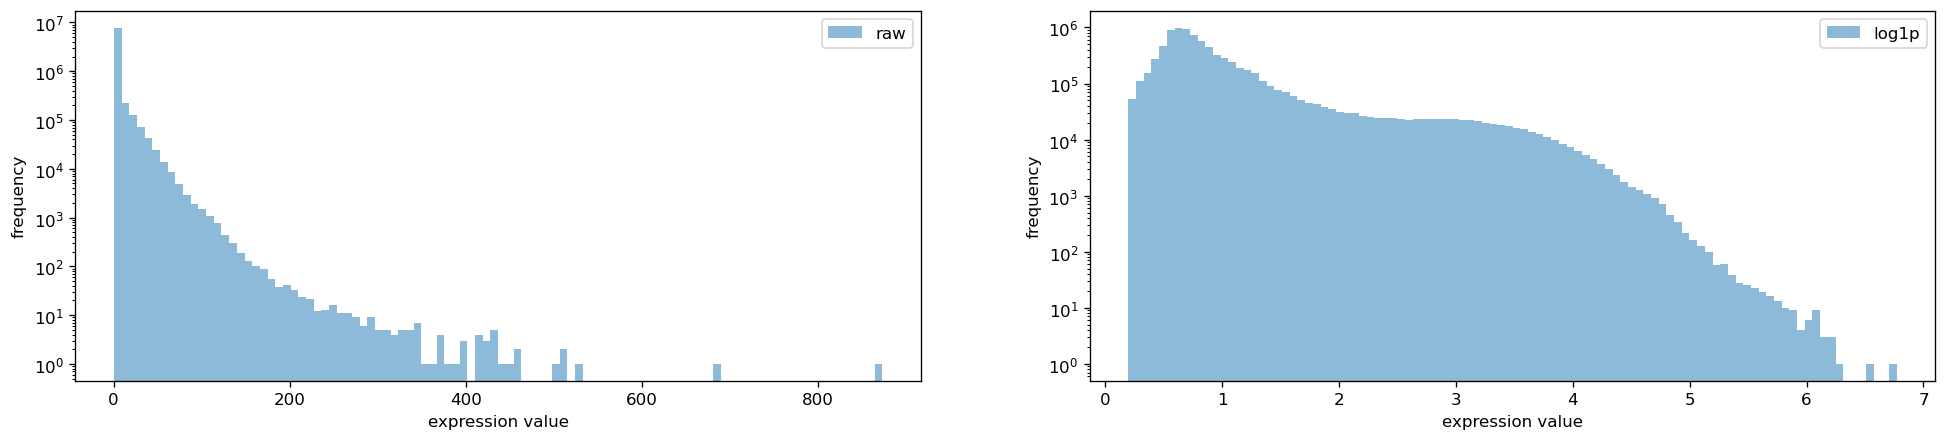

In [30]:
import matplotlib.pyplot as plt

# raw counts (non-zero only)
raw_nonzero = adata.layers["counts"].data
normalized_nonzero = adata_pp.layers["norm"].data

# log1p values (non-zero only)
log_nonzero = adata_pp.X.data

plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.hist(normalized_nonzero, bins=100, alpha=0.5, label="raw")
plt.yscale("log")
plt.legend()
plt.xlabel("expression value")
plt.ylabel("frequency")
plt.subplot(1,2,2)
plt.hist(log_nonzero, bins=100, alpha=0.5, label="log1p")
plt.yscale("log")
plt.legend()
plt.xlabel("expression value")
plt.ylabel("frequency")


In [31]:
sc.tl.pca(adata_pp)

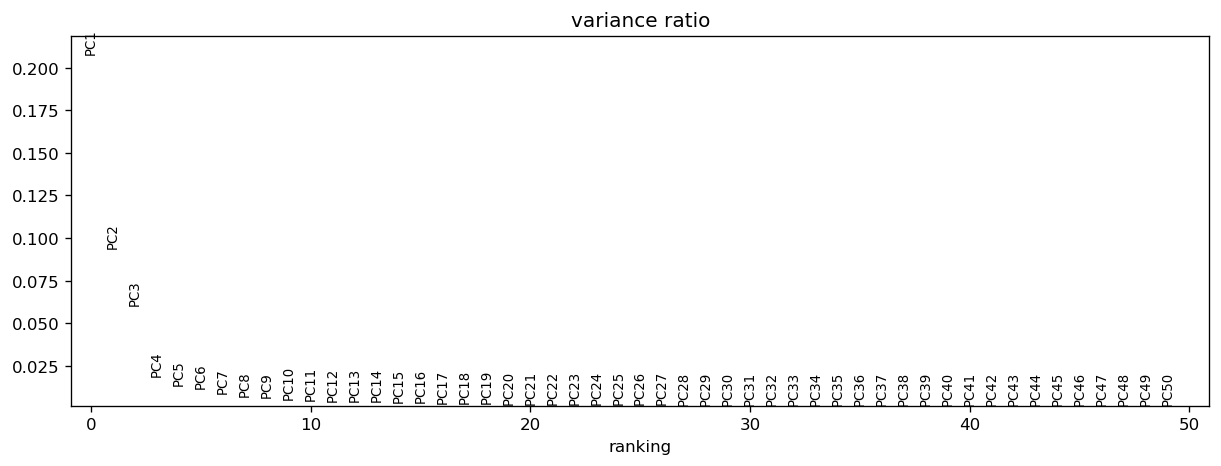

In [34]:
sc.pl.pca_variance_ratio(adata_pp, n_pcs=50)

In [36]:
sc.pp.neighbors(adata_pp)  #builds a k-nearest-neighbor (kNN) graph of cells based on their gene-expression similarity. That graph is the backbone for clustering, UMAP, and many downstream analyses in Scanpy.

In [39]:
plt.rcParams["figure.figsize"] = (12, 12)   # width, height in inches
plt.rcParams["figure.dpi"] = 120
sc.tl.umap(adata_pp) #dimentionality reduction

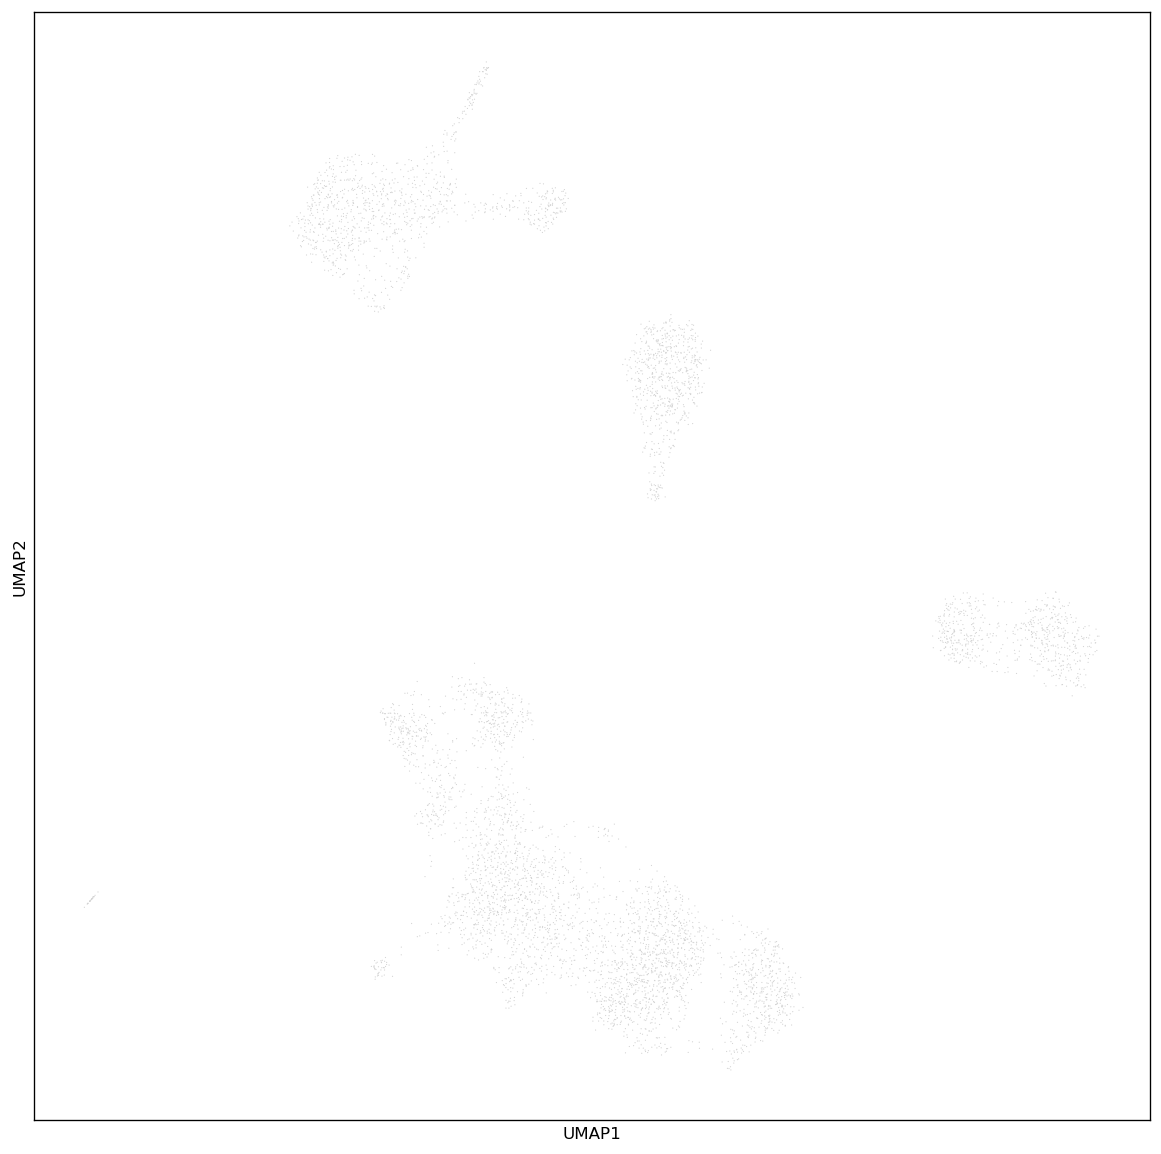

In [40]:
sc.pl.umap(
    adata_pp,
    # Setting a smaller point size to get prevent overlap
    size=2,
)

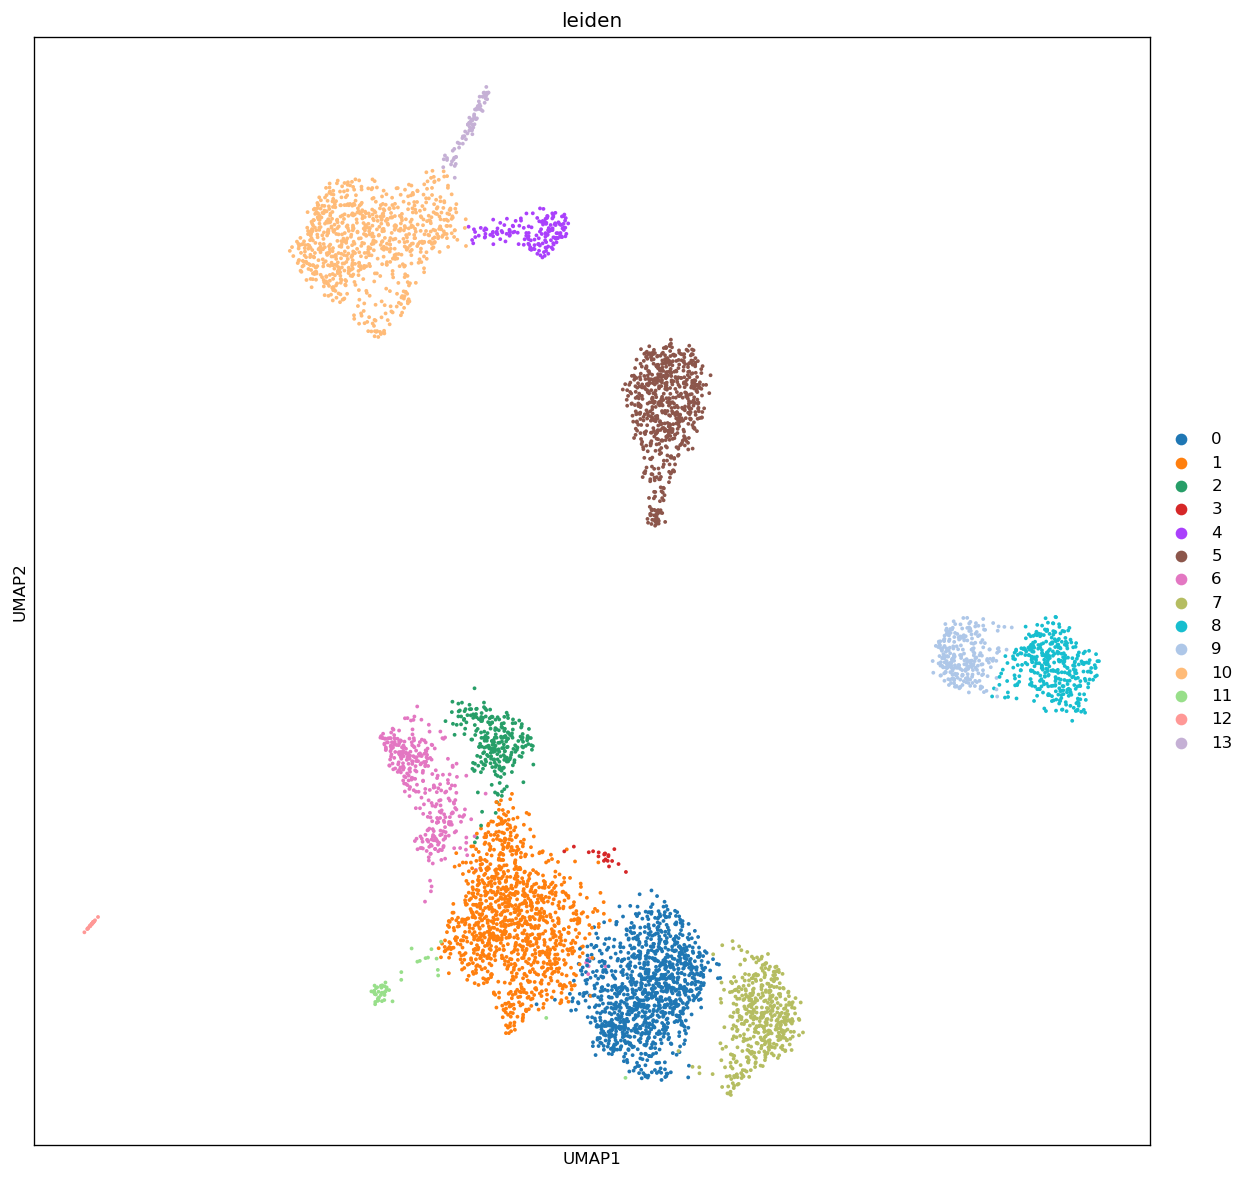

In [41]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster,
# especially for larger datasets
sc.tl.leiden(adata_pp, flavor="igraph", n_iterations=2)
sc.pl.umap(adata_pp, color=["leiden"])

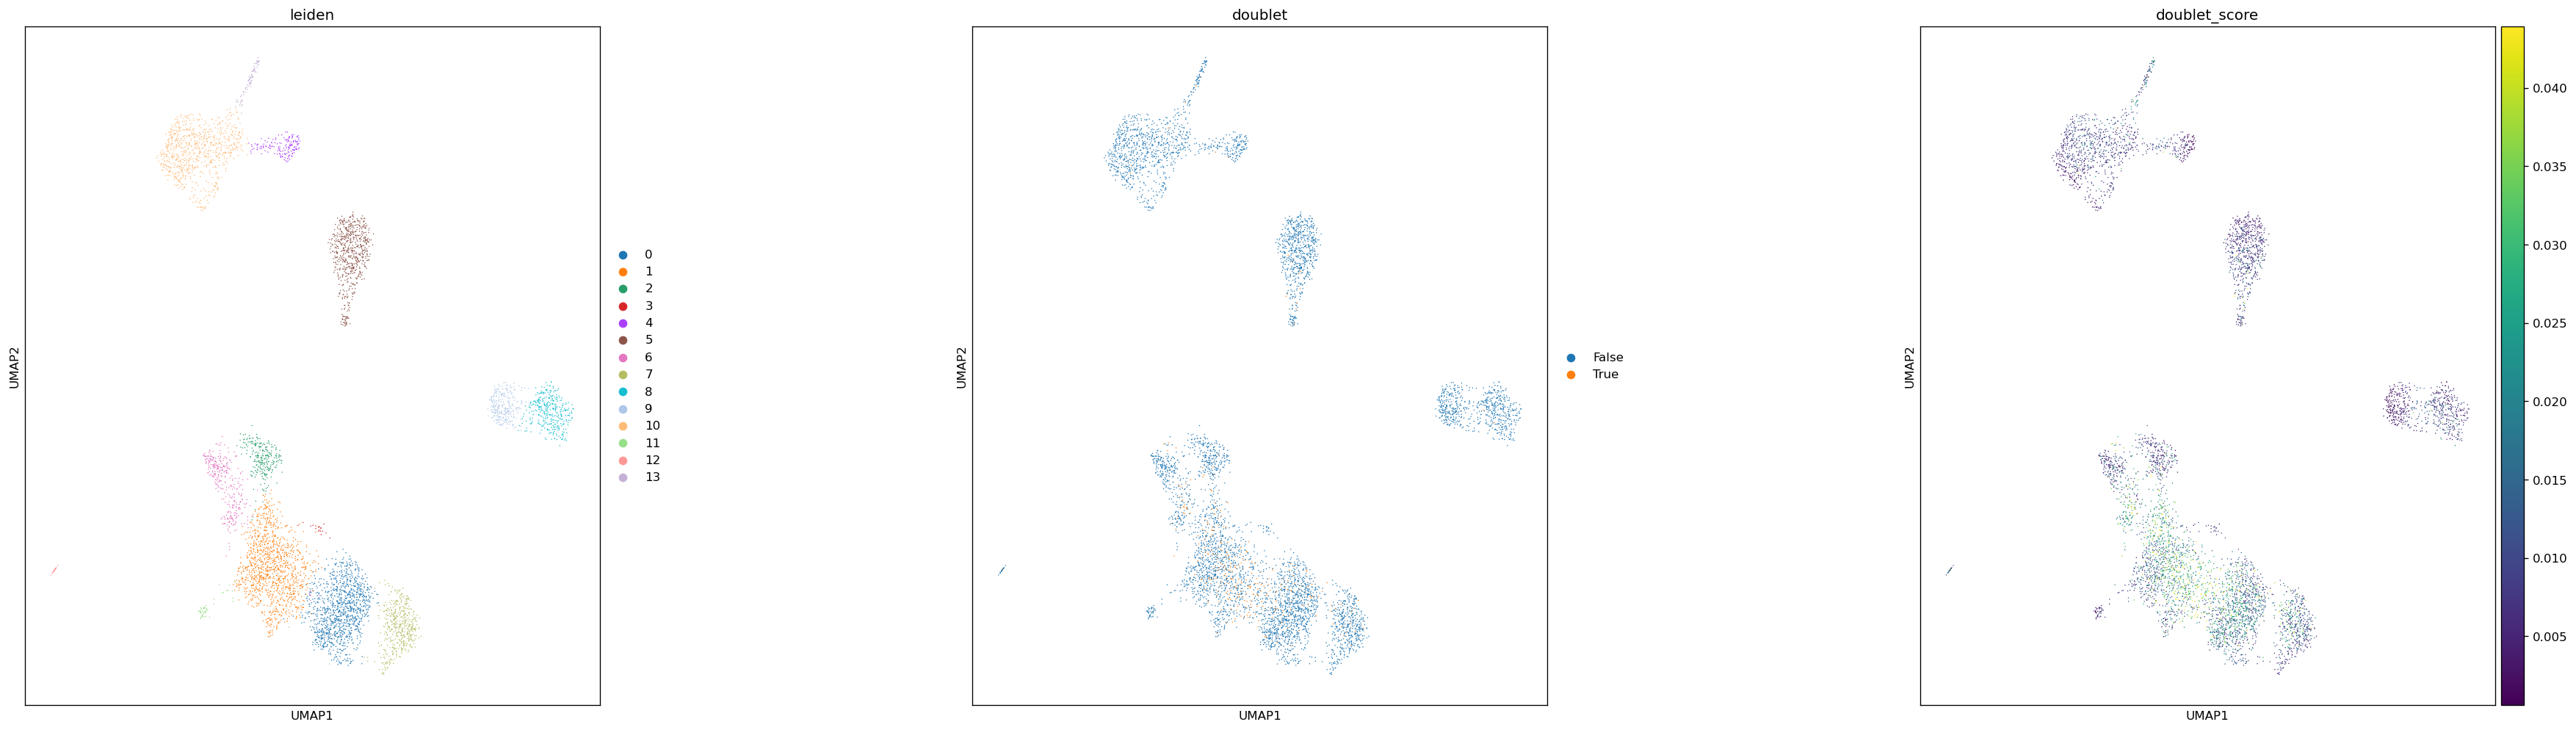

In [42]:
plt.rcParams["figure.figsize"] = (8, 10)   # width, height in inches
plt.rcParams["figure.dpi"] = 120
sc.pl.umap(
    adata_pp,
    color=["leiden", "doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

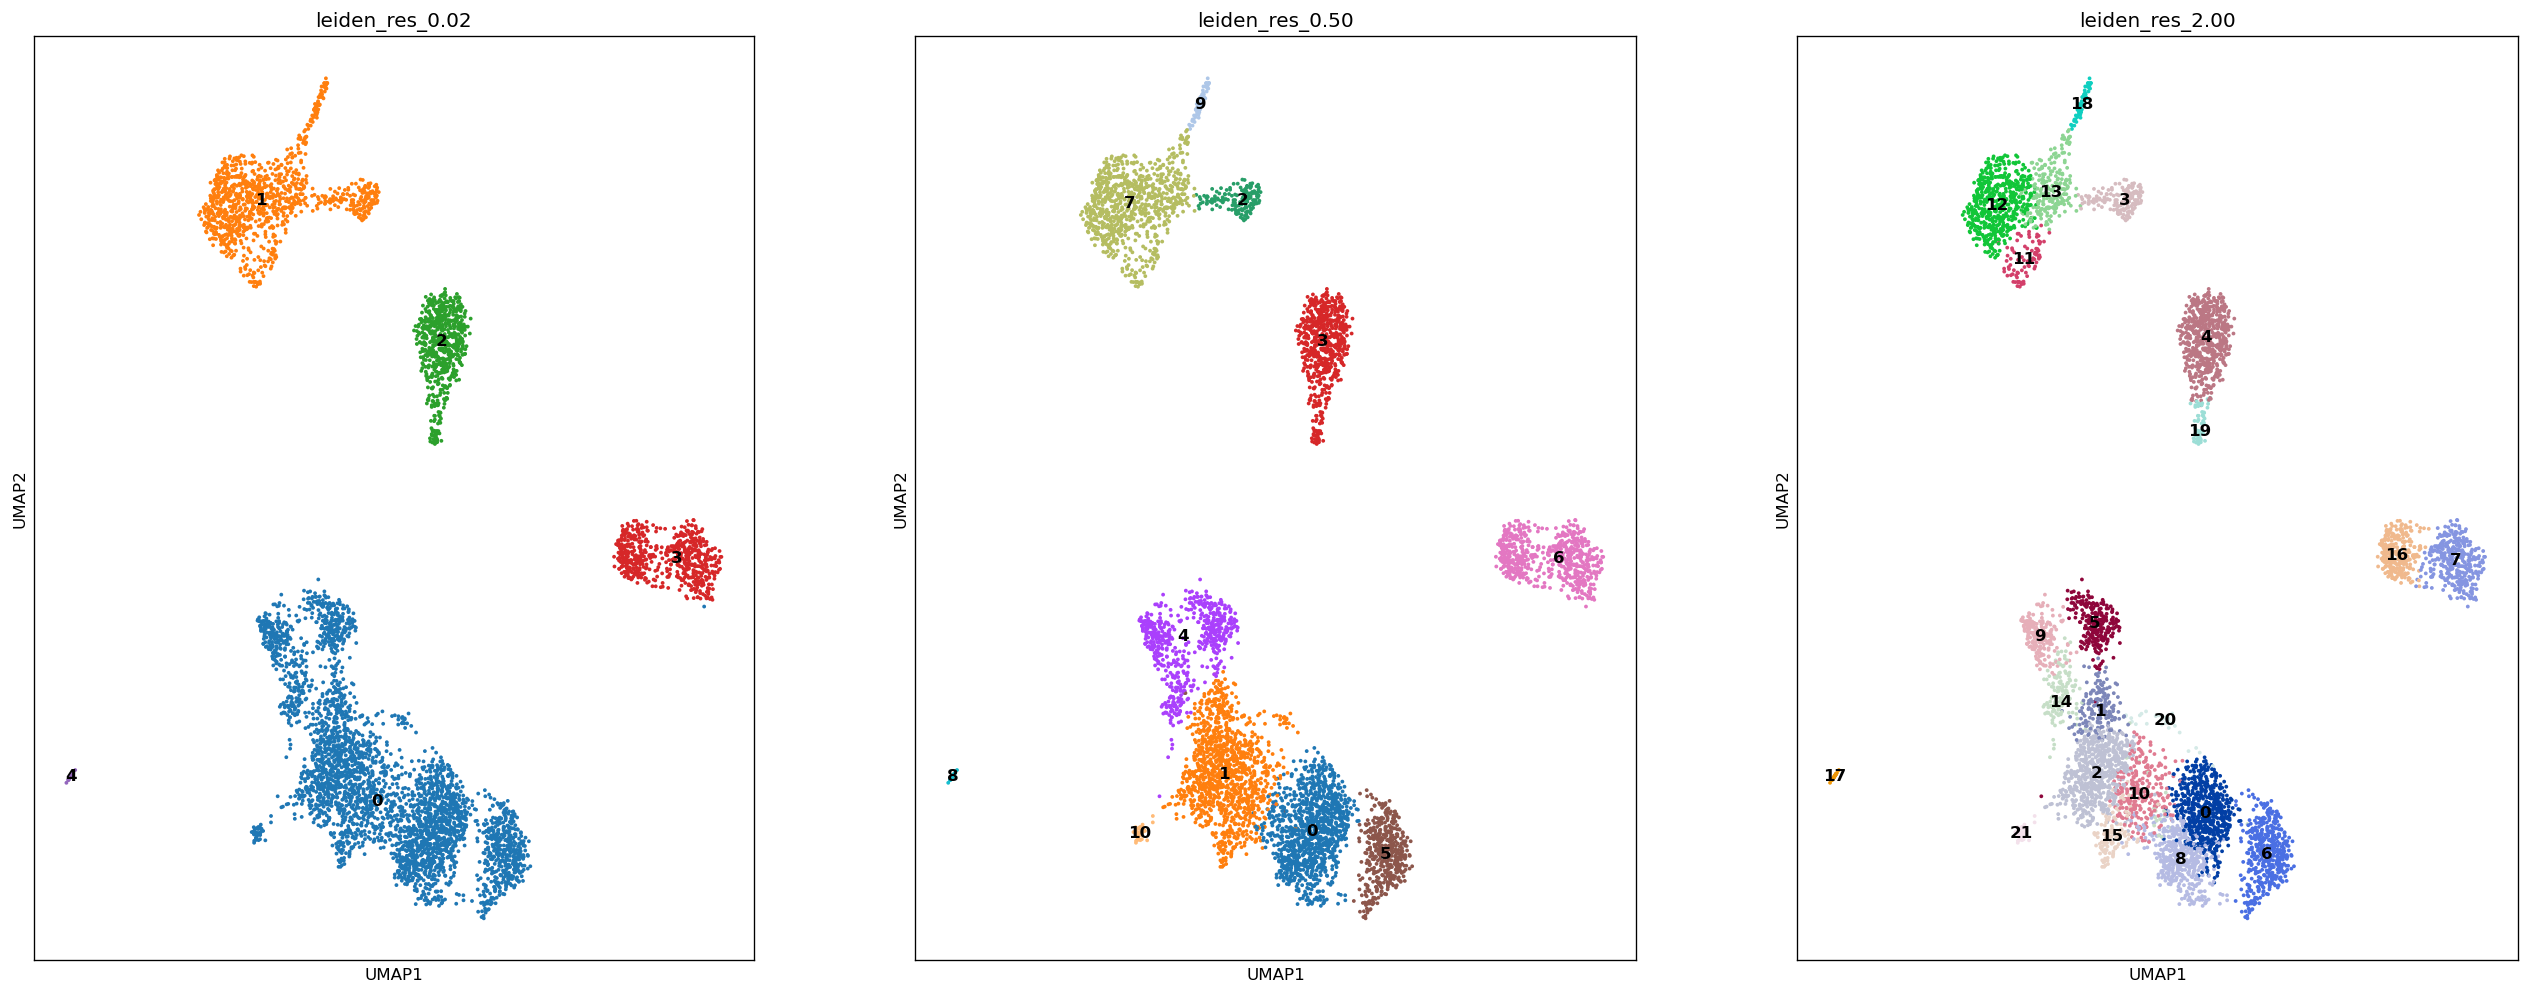

In [43]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(adata_pp, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")
sc.pl.umap(
    adata_pp,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

In [44]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

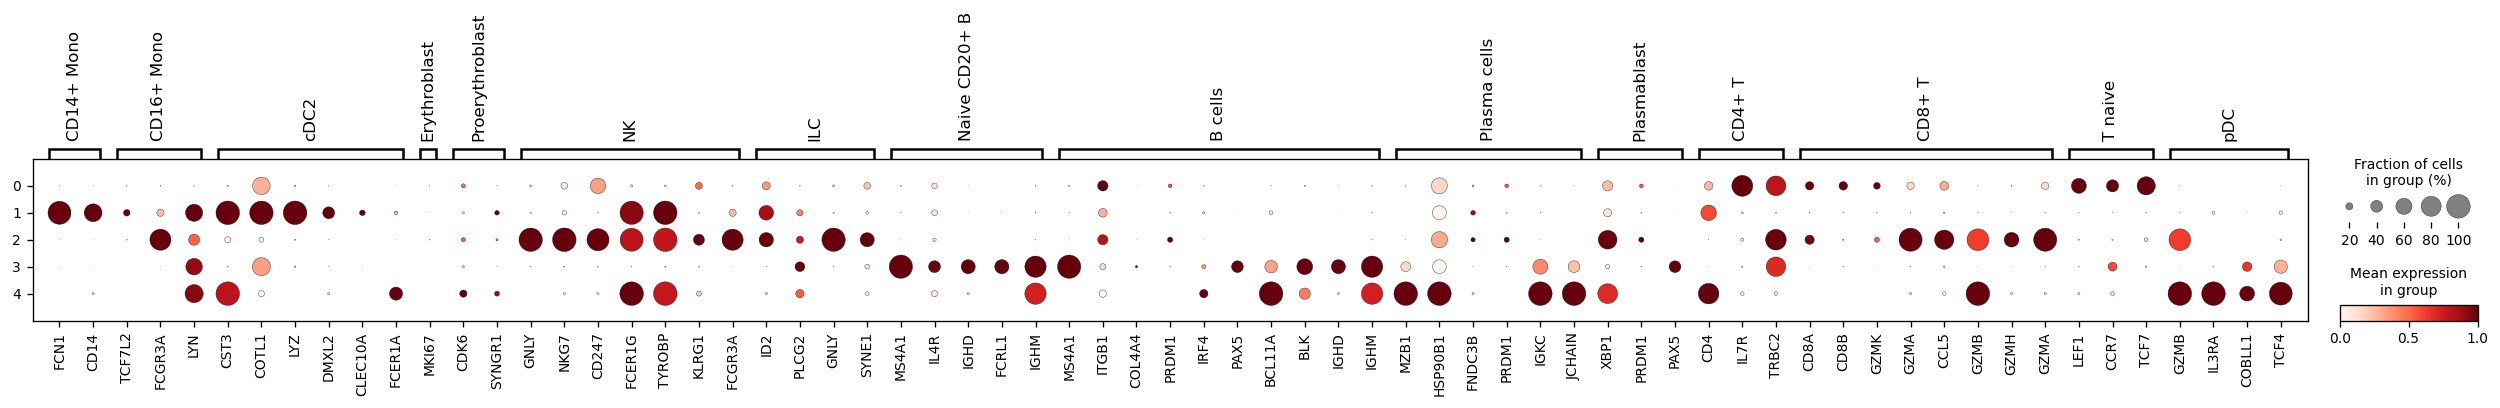

In [45]:
sc.pl.dotplot(adata_pp, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

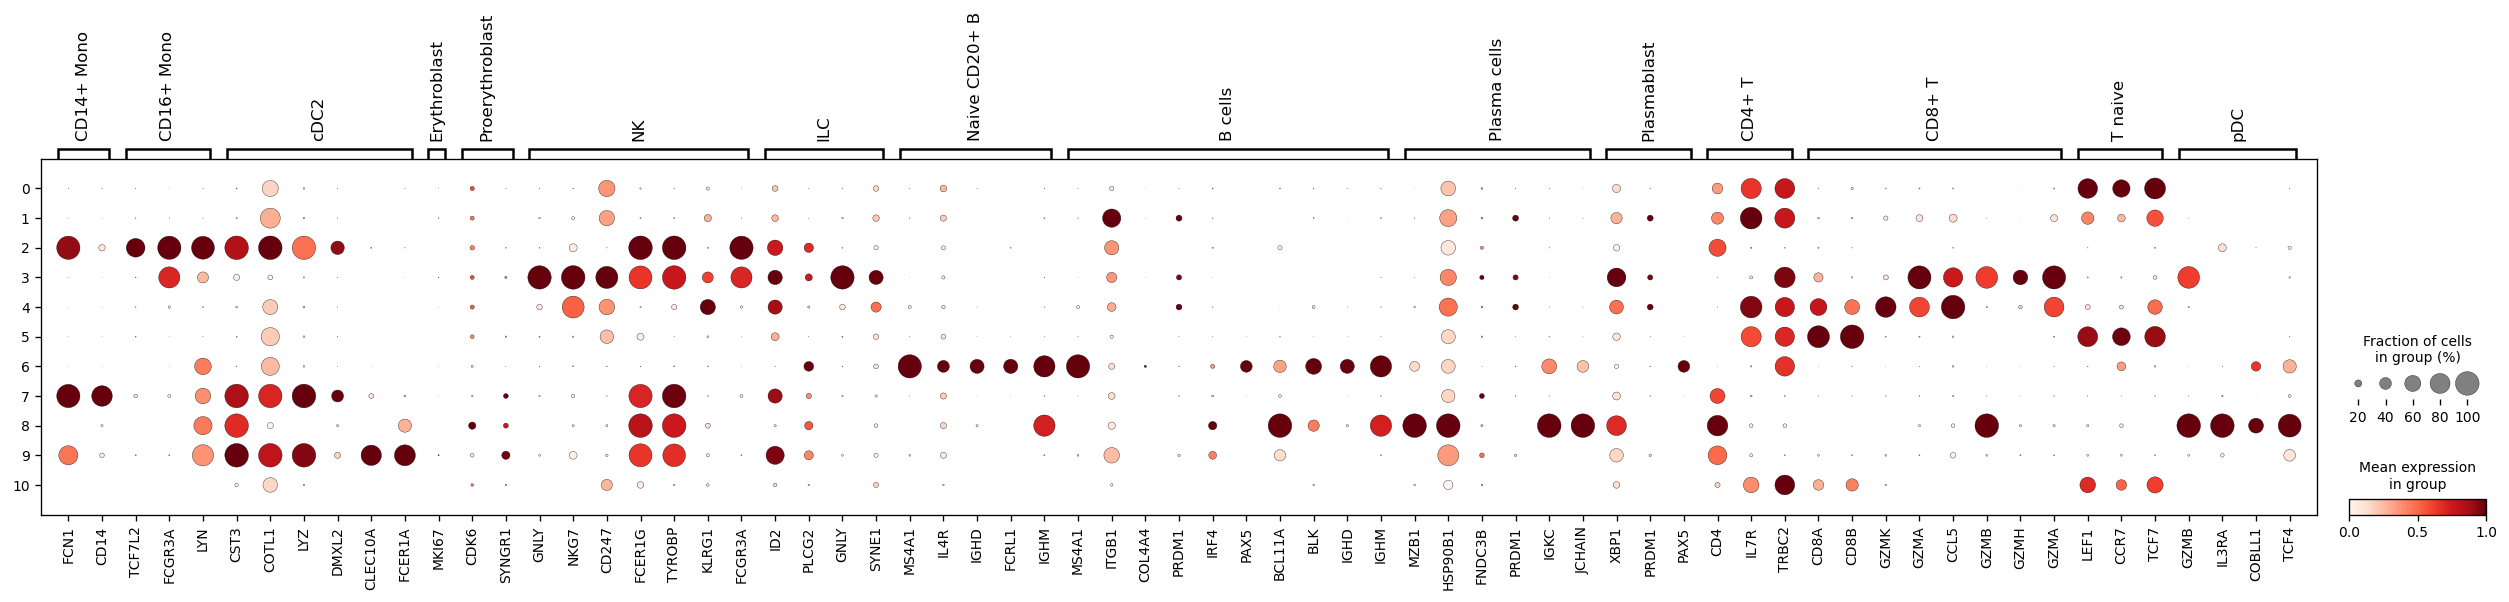

In [47]:
sc.pl.dotplot(adata_pp, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

In [48]:
adata_pp.obs["cell_type_lvl1"] = adata_pp.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
         "4": "Unknown",
    }
)

In [49]:
adata_pp.obs["cell_type_lvl1"]

AAACCTGAGATCTGAA-1    Lymphocytes
AAACCTGAGGAACTGC-1    Lymphocytes
AAACCTGAGGAGTCTG-1    Lymphocytes
AAACCTGAGGCTCTTA-1    Lymphocytes
AAACCTGAGTACGTTC-1      Monocytes
                         ...     
TTTGTCAGTTGGTGGA-1    Lymphocytes
TTTGTCATCACGGTTA-1    Lymphocytes
TTTGTCATCCCTTGTG-1    Lymphocytes
TTTGTCATCGGAAATA-1    Lymphocytes
TTTGTCATCTAGAGTC-1      Monocytes
Name: cell_type_lvl1, Length: 5774, dtype: category
Categories (5, object): ['Lymphocytes', 'Monocytes', 'Erythroid', 'B Cells', 'Unknown']

In [50]:
agg=sc.get.aggregate(adata_pp, by=["cell_type_lvl1"], func="sum", layer="counts")

In [51]:
df = pd.DataFrame(
    agg.layers["sum"],
    index=agg.obs_names,   # row labels (clusters)
    columns=agg.var_names, # column labels (genes)
)

In [52]:
df#.to_csv("aggregated_counts_leiden_0.50.csv")

,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AL592183.1,AC240274.1
Lymphocytes,129.0,48.0,48.0,597.0,25.0,18.0,6.0,1266.0,6.0,100.0,...,77688.0,69644.0,72102.0,26251.0,35572.0,5386.0,73404.0,16.0,16.0,27.0
Monocytes,59.0,32.0,23.0,211.0,28.0,3.0,269.0,520.0,13.0,33.0,...,50181.0,33696.0,26793.0,17669.0,15675.0,1895.0,30586.0,4.0,15.0,32.0
Erythroid,15.0,8.0,5.0,93.0,2.0,2.0,3.0,273.0,1.0,17.0,...,13125.0,8422.0,12274.0,4452.0,7496.0,1201.0,8026.0,1.0,6.0,10.0
B Cells,28.0,10.0,12.0,104.0,3.0,0.0,1.0,139.0,3.0,17.0,...,22248.0,17050.0,19482.0,6959.0,8054.0,1659.0,14372.0,2.0,8.0,9.0
Unknown,1.0,2.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,...,569.0,369.0,485.0,219.0,327.0,30.0,346.0,0.0,0.0,0.0
